# ResNet152 and VGG19 Performance on Image-level

# Image Processing

In [24]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models

# ----------------------------------------------------------------------------------------------
# Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Randomly rotate the image up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.RandomPerspective(),  # Random perspective transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

dataset = ImageFolder(root='/local/data1/honzh073/data/8bit_image', transform=transform)

# ----------------------------------------------------------------------------------------------
# Random seed
# seed = 123
# random.seed(seed)
# torch.manual_seed(seed)
# ----------------------------------------------------------------------------------------------
# Split dataset into 80% train, 10% validation, and 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# DataLoader for training, validation, and testing
batch_size = 64

# Move data loaders to GPU if available
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0")  # Use GPU 0
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is available!
done!


# Plot 8 bit Images

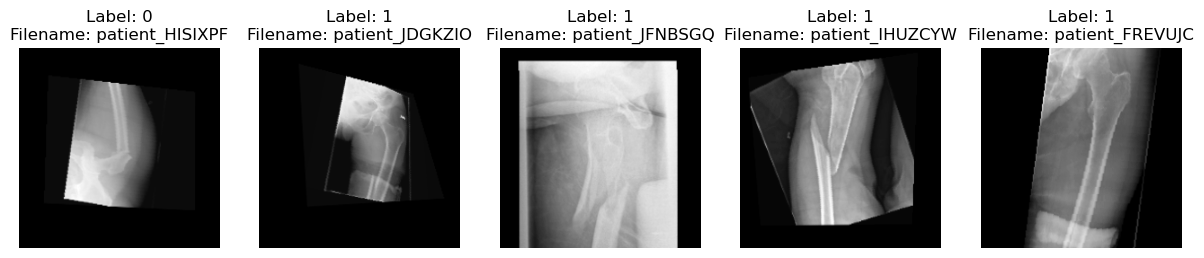

In [7]:
# # ---------------------------------------------------------------------------------
# # Get some random indices from the training dataset
# random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# # Plot images (transformed)
# plt.figure(figsize=(15, 5))
# for i, idx in enumerate(random_indices):
#     image, label = train_dataset[idx]
#     plt.subplot(1, 5, i + 1)
#     plt.title(f"Label: {label}")
#     # plt.imshow(image[0])  # 3-channel (RGB)
#     plt.imshow(image[0], cmap='gray')  #single-channel (grayscale)
#     plt.axis('off')
# plt.show()

# Get some random indices from the training dataset
random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# Plot images (transformed) with truncated names
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    filename = validation_dataset.dataset.samples[idx][0]  # Get the filename
    truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}\nFilename: {truncated_filename}")
    # plt.imshow(image[0])  # 3-channel (RGB)
    plt.imshow(image[0], cmap='gray')  # Single-channel (grayscale)
    plt.axis('off')
plt.show()



# Class weights of Training Dataset

In [15]:
# ---------------------------------------------------------------------------------
# aff and nff numbers in dataset
aff_count = sum(1 for _, label in dataset if label == 0)  # 0 AFF
nff_count = sum(1 for _, label in dataset if label == 1)  # 1 NFF

# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# aff and nff numbers in val dataset
valid_aff_count = sum(1 for _, label in validation_dataset if label == 0)
valid_nff_count = sum(1 for _, label in validation_dataset if label == 1)

# aff and nff numbers in test dataset
test_aff_count = sum(1 for _, label in test_dataset if label == 0)
test_nff_count = sum(1 for _, label in test_dataset if label == 1)

print(f"aff number: {aff_count}")
print(f"nff number: {nff_count}")

print(f"train aff number: {train_aff_count}")
print(f"train nff number: {train_nff_count}")
print(f"val aff number: {valid_aff_count}")
print(f"val nff number: {valid_nff_count}")
print(f"test aff number: {test_aff_count}")
print(f"test nff number: {test_nff_count}")

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


aff number: 868
nff number: 3474
train aff number: 702
train nff number: 2771
val aff number: 81
val nff number: 353
test aff number: 85
test nff number: 350
Class Weight for AFF (0): 2.4736
Class Weight for NFF (1): 0.6267


In [16]:
import numpy as np

# Extract labels from the dataset
labels = np.array([label for _, label in dataset])

# Count aff and nff numbers in the entire dataset
aff_count = np.sum(labels == 0)  # 0 AFF
nff_count = np.sum(labels == 1)  # 1 NFF

# Count aff and nff numbers in the training dataset
train_labels = np.array([label for _, label in train_dataset])
train_aff_count = np.sum(train_labels == 0)  # 0 AFF
train_nff_count = np.sum(train_labels == 1)  # 1 NFF

# Count aff and nff numbers in the validation dataset
valid_labels = np.array([label for _, label in validation_dataset])
valid_aff_count = np.sum(valid_labels == 0)
valid_nff_count = np.sum(valid_labels == 1)

# Count aff and nff numbers in the test dataset
test_labels = np.array([label for _, label in test_dataset])
test_aff_count = np.sum(test_labels == 0)
test_nff_count = np.sum(test_labels == 1)

print(f"aff number: {aff_count}")
print(f"nff number: {nff_count}")

print(f"train aff number: {train_aff_count}")
print(f"train nff number: {train_nff_count}")
print(f"val aff number: {valid_aff_count}")
print(f"val nff number: {valid_nff_count}")
print(f"test aff number: {test_aff_count}")
print(f"test nff number: {test_nff_count}")

# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


aff number: 868
nff number: 3474
train aff number: 702
train nff number: 2771
val aff number: 81
val nff number: 353
test aff number: 85
test nff number: 350
Class Weight for AFF (0): 2.4736
Class Weight for NFF (1): 0.6267


# ResNet152
# Train on Training and Validation Dataset
# Test Performance
## 0.0001, 10, 0.1

Epoch 1/50, Train Loss: 0.5978, Validation Loss: 0.5586, Train Acc: 65.25%, Validation Acc: 76.73%
Epoch 2/50, Train Loss: 0.5142, Validation Loss: 0.4033, Train Acc: 80.51%, Validation Acc: 82.49%
Epoch 3/50, Train Loss: 0.3725, Validation Loss: 0.3322, Train Acc: 86.12%, Validation Acc: 84.79%
Epoch 4/50, Train Loss: 0.2315, Validation Loss: 0.2420, Train Acc: 88.68%, Validation Acc: 92.63%
Epoch 5/50, Train Loss: 0.2680, Validation Loss: 0.3181, Train Acc: 90.12%, Validation Acc: 90.78%
Epoch 6/50, Train Loss: 0.1941, Validation Loss: 0.2084, Train Acc: 90.79%, Validation Acc: 89.17%
Epoch 7/50, Train Loss: 0.3948, Validation Loss: 0.2521, Train Acc: 91.71%, Validation Acc: 87.56%
Epoch 8/50, Train Loss: 0.2665, Validation Loss: 0.2339, Train Acc: 92.89%, Validation Acc: 88.71%
Epoch 9/50, Train Loss: 0.2498, Validation Loss: 0.2114, Train Acc: 92.89%, Validation Acc: 91.01%
Epoch 10/50, Train Loss: 0.3665, Validation Loss: 0.2118, Train Acc: 93.52%, Validation Acc: 91.01%
Epoch 11/

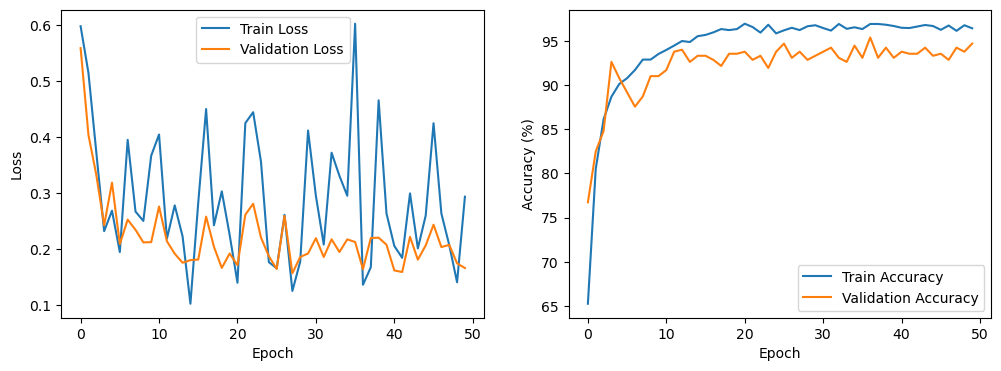

Test Loss: 0.2403, Test Acc: 91.95%


In [17]:
from torchvision.models import resnet152, ResNet152_Weights
# ----------------------------------------------------------------------------------------------
# Settings
lr = 0.0001 # the lr should be smaller
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet152
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model = model.to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# ----------------------------------------------------------------------------------------------
# Training and validation
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler
# ----------------------------------------------------------------------------------------------
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()
# ----------------------------------------------------------------------------------------------
# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# 0.0001, 10, 0.1

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

original_classes = train_loader.dataset.dataset.classes

# confusion matrix
with torch.no_grad():
    all_predictions = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Precision、Recall、F1 Score
classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
# 85 AFF 350 NFF

Confusion Matrix:
[[ 75  10]
 [ 25 325]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.75      0.88      0.81        85
         NFF       0.97      0.93      0.95       350

    accuracy                           0.92       435
   macro avg       0.86      0.91      0.88       435
weighted avg       0.93      0.92      0.92       435



## 0.00001, 10, 0.1

Epoch 1/50, Train Loss: 0.6925, Validation Loss: 0.6835, Train Acc: 52.89%, Validation Acc: 65.67%
Epoch 2/50, Train Loss: 0.6726, Validation Loss: 0.6746, Train Acc: 58.54%, Validation Acc: 60.14%
Epoch 3/50, Train Loss: 0.5965, Validation Loss: 0.6483, Train Acc: 59.52%, Validation Acc: 63.82%
Epoch 4/50, Train Loss: 0.6076, Validation Loss: 0.6343, Train Acc: 66.83%, Validation Acc: 70.05%
Epoch 5/50, Train Loss: 0.5820, Validation Loss: 0.5899, Train Acc: 69.31%, Validation Acc: 68.43%
Epoch 6/50, Train Loss: 0.4823, Validation Loss: 0.5572, Train Acc: 70.14%, Validation Acc: 74.19%
Epoch 7/50, Train Loss: 0.5065, Validation Loss: 0.5366, Train Acc: 76.07%, Validation Acc: 75.35%
Epoch 8/50, Train Loss: 0.4100, Validation Loss: 0.5075, Train Acc: 79.36%, Validation Acc: 76.04%
Epoch 9/50, Train Loss: 0.3430, Validation Loss: 0.4254, Train Acc: 79.59%, Validation Acc: 81.80%
Epoch 10/50, Train Loss: 0.3641, Validation Loss: 0.4000, Train Acc: 82.95%, Validation Acc: 82.72%
Epoch 11/

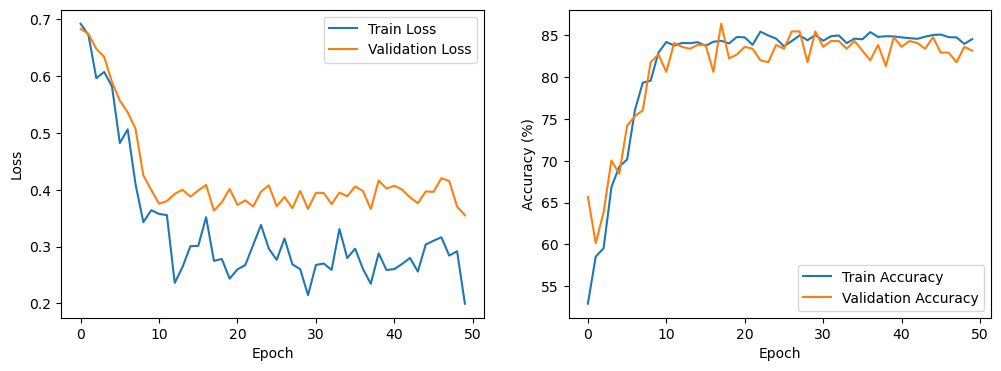

Test Loss: 0.3566, Test Acc: 84.14%


In [13]:
from torchvision.models import resnet152, ResNet152_Weights
# ----------------------------------------------------------------------------------------------
# Settings
lr = 0.00001 # the lr should be smaller
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet152
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model = model.to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# ----------------------------------------------------------------------------------------------
# Training and validation
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler
# ----------------------------------------------------------------------------------------------
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()
# ----------------------------------------------------------------------------------------------
# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# 0.00001, 10, 0.1

# Save the Model

In [ ]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'resnet152_xray_classifier.pth')


# Clean GPU Memory

In [9]:
torch.cuda.empty_cache()


# VGG19
## 0.0001, 10, 0.1

Epoch 1/50, Train Loss: 0.6345, Validation Loss: 0.6541, Train Acc: 57.59%, Validation Acc: 35.48%
Epoch 2/50, Train Loss: 0.4443, Validation Loss: 0.5056, Train Acc: 75.04%, Validation Acc: 83.41%
Epoch 3/50, Train Loss: 0.3714, Validation Loss: 0.4230, Train Acc: 80.22%, Validation Acc: 82.95%
Epoch 4/50, Train Loss: 0.3576, Validation Loss: 0.4169, Train Acc: 84.54%, Validation Acc: 80.18%
Epoch 5/50, Train Loss: 0.3302, Validation Loss: 0.4001, Train Acc: 83.82%, Validation Acc: 85.25%
Epoch 6/50, Train Loss: 0.3170, Validation Loss: 0.3895, Train Acc: 85.66%, Validation Acc: 89.17%
Epoch 7/50, Train Loss: 0.2695, Validation Loss: 0.3714, Train Acc: 86.15%, Validation Acc: 83.87%
Epoch 8/50, Train Loss: 0.2904, Validation Loss: 0.4692, Train Acc: 84.74%, Validation Acc: 83.64%
Epoch 9/50, Train Loss: 0.4101, Validation Loss: 0.4012, Train Acc: 85.52%, Validation Acc: 86.41%
Epoch 10/50, Train Loss: 0.2758, Validation Loss: 0.4225, Train Acc: 84.71%, Validation Acc: 89.63%
Epoch 11/

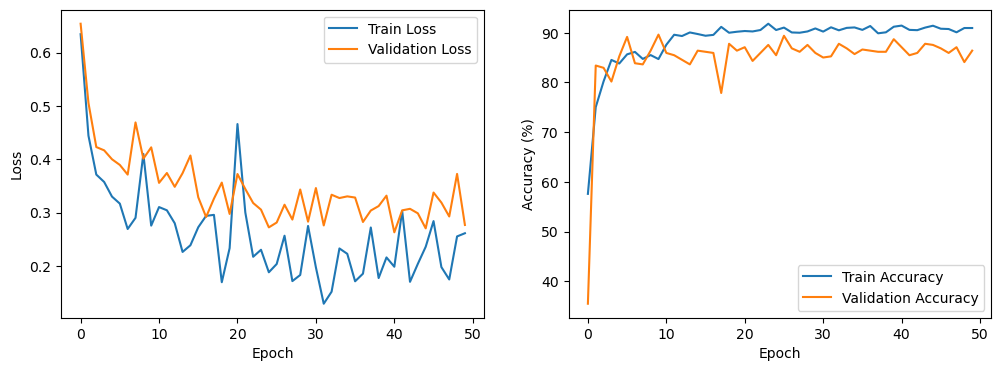

Test Loss: 0.2396, Test Acc: 89.89%


In [10]:
from torchvision.models import vgg19, VGG19_Weights
# ----------------------------------------------------------------------------------------------
# Settings
lr = 0.0001  # You can adjust the learning rate as needed
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# VGG19
model = models.vgg19(weights=VGG19_Weights.DEFAULT)  # Load the pre-trained VGG19 model
model.classifier[6] = nn.Linear(4096, 2)  # Modify the last fully connected layer
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training and validation
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)

    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")

    scheduler.step()  # Step the learning rate scheduler
# ----------------------------------------------------------------------------------------------
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# ----------------------------------------------------------------------------------------------
# Test performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# 0.0001, 10, 0.1

# VGG19
## 0.00001, 10, 0.1

Epoch 1/50, Train Loss: 0.5987, Validation Loss: 0.6373, Train Acc: 56.23%, Validation Acc: 65.67%
Epoch 2/50, Train Loss: 0.5164, Validation Loss: 0.5723, Train Acc: 68.87%, Validation Acc: 74.88%
Epoch 3/50, Train Loss: 0.4132, Validation Loss: 0.5013, Train Acc: 74.17%, Validation Acc: 75.12%
Epoch 4/50, Train Loss: 0.4398, Validation Loss: 0.4620, Train Acc: 78.43%, Validation Acc: 82.26%
Epoch 5/50, Train Loss: 0.4861, Validation Loss: 0.4774, Train Acc: 79.18%, Validation Acc: 83.87%
Epoch 6/50, Train Loss: 0.3675, Validation Loss: 0.4324, Train Acc: 83.16%, Validation Acc: 83.64%
Epoch 7/50, Train Loss: 0.4540, Validation Loss: 0.4161, Train Acc: 82.70%, Validation Acc: 81.57%
Epoch 8/50, Train Loss: 0.4255, Validation Loss: 0.4264, Train Acc: 85.03%, Validation Acc: 81.34%
Epoch 9/50, Train Loss: 0.2896, Validation Loss: 0.3593, Train Acc: 85.32%, Validation Acc: 81.57%
Epoch 10/50, Train Loss: 0.3563, Validation Loss: 0.3910, Train Acc: 85.08%, Validation Acc: 80.88%
Epoch 11/

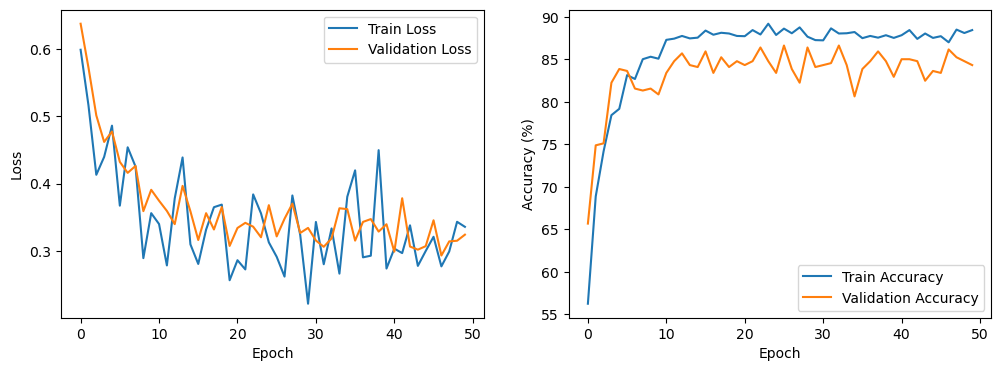

Test Loss: 0.3013, Test Acc: 87.59%


In [12]:
from torchvision.models import vgg19, VGG19_Weights
# ----------------------------------------------------------------------------------------------
# Settings
lr = 0.00001  # You can adjust the learning rate as needed
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# VGG19
model = models.vgg19(weights=VGG19_Weights.DEFAULT)  # Load the pre-trained VGG19 model
model.classifier[6] = nn.Linear(4096, 2)  # Modify the last fully connected layer
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# ----------------------------------------------------------------------------------------------
# Training and validation
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)

    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")

    scheduler.step()  # Step the learning rate scheduler
# ----------------------------------------------------------------------------------------------
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# ----------------------------------------------------------------------------------------------
# Test the model on the test dataset
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# 0.00001, 10, 0.1